In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
import glob

In [2]:
%matplotlib inline

## Constants

In [3]:
IMG_WIDTH = 100
IMG_HEIGHT = 100

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data loading

In [5]:
%cd "drive/MyDrive/Material Machine Learning /CNN (modelo) /Modelo"

/content/drive/MyDrive/Material Machine Learning /CNN (modelo) /Modelo


In [6]:
pictures = glob.glob("Pictures/*/*") # Let's get all the filepaths of all the images

### Check images

In [7]:
import os
from PIL import Image
def check_images():
    folder_path = r'Pictures'
    extensions = []
    for fldr in os.listdir(folder_path):
        sub_folder_path = os.path.join(folder_path, fldr)
        for filee in os.listdir(sub_folder_path):
            file_path = os.path.join(sub_folder_path, filee)
            print('** Path: {}  **'.format(file_path), end="\r", flush=True)
            im = Image.open(file_path)
            rgb_im = im.convert('RGB')
            if filee.split('.')[1] not in extensions:
                extensions.append(filee.split('.')[1])

# Run to verify if all images are correct
check_images()

In [8]:
df = pd.DataFrame() # Create empty df
df['filepath'] = pictures # Put all the paths in the filepath folder

df['label'] = df.filepath.str.split("/").str.get(1) # The label is after the first slash

In [9]:
NUM_CATEGORIES = df.label.nunique() # Classes in our dataset

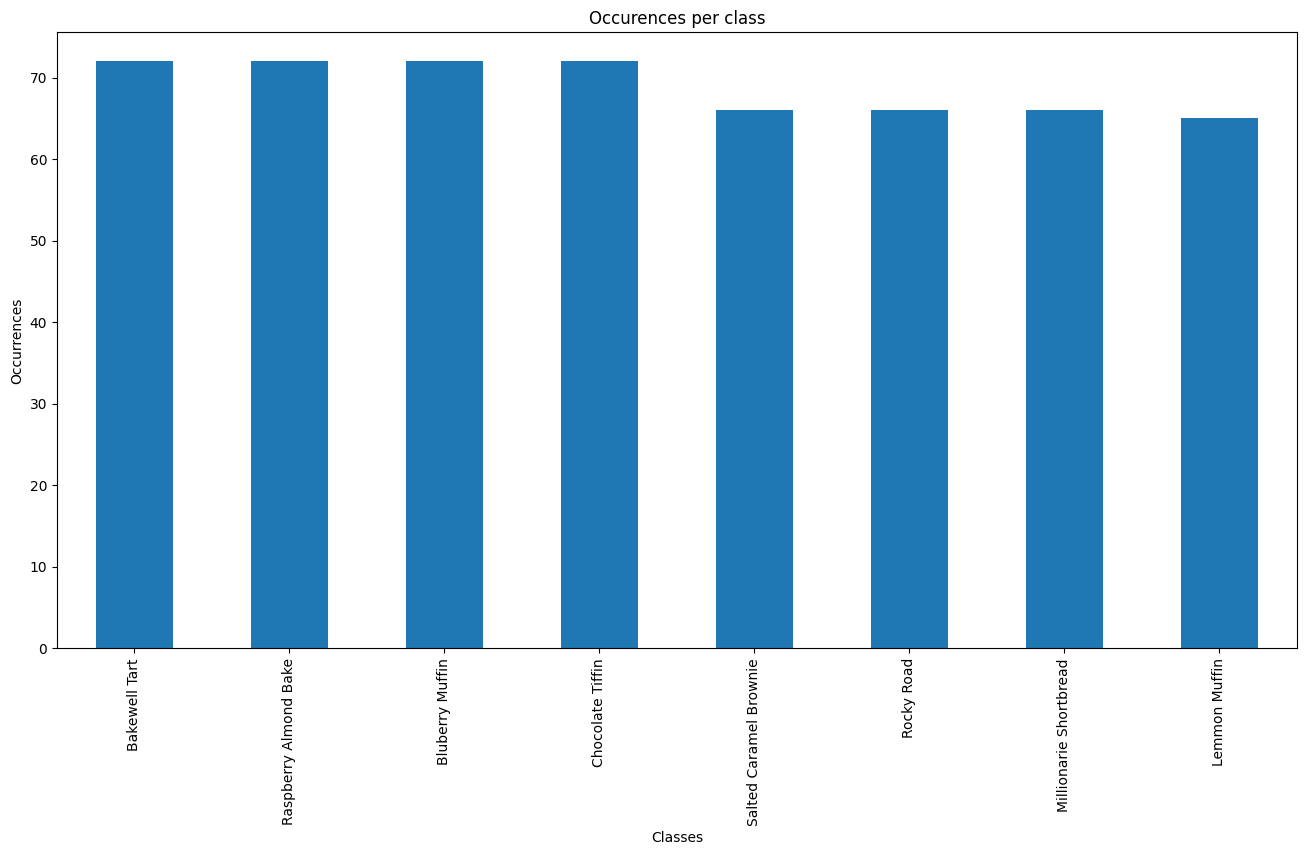

In [10]:
fig, ax = plt.subplots(figsize=(16, 8))

df.label.value_counts().plot.bar()
plt.title("Occurences per class")
plt.xticks(rotation=90)
plt.xlabel('Classes')
plt.ylabel('Occurrences')
plt.show()

In [11]:
class_counter = df.label.value_counts()
print("Times each class appears in order")
print("------------------------------------------------------------")
for key, values in class_counter.items():
    print(f"{key:50} ===> {values:4}")

Times each class appears in order
------------------------------------------------------------
Bakewell Tart                                      ===>   72
Raspberry Almond Bake                              ===>   72
Bluberry Muffin                                    ===>   72
Chocolate Tiffin                                   ===>   72
Salted Caramel Brownie                             ===>   66
Rocky Road                                         ===>   66
Millionarie Shortbread                             ===>   66
Lemmon Muffin                                      ===>   65


We will use accuracy as a metric to measure how well our model performs...

## What does each class looks like

In [12]:
import matplotlib.image as mpimg

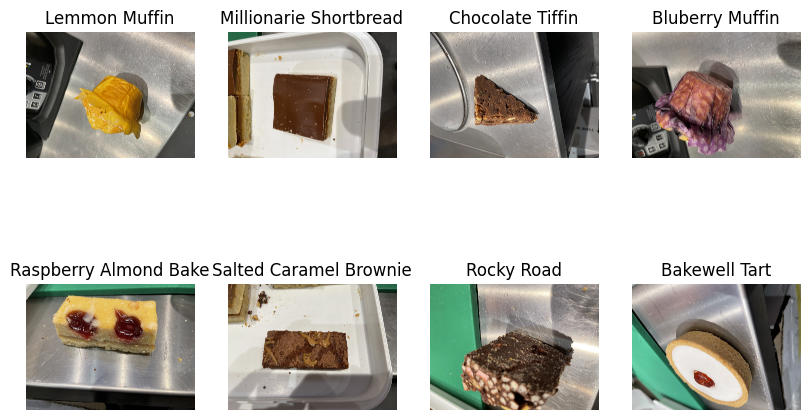

In [13]:
fig, axs = plt.subplots(2, 4, figsize=(10, 6)) # 2x4 plot
axs = axs.flatten() # Flatten the axes so we can access them with an index

unique_classes = set(df['label']) # Get all the unique labels

for i, class_name in enumerate(unique_classes): # Let's iterate
    image_path = df.loc[df.label == class_name].filepath.iloc[0] # Get the first image with that label
    image = mpimg.imread(image_path) # Read the image
    axs[i].imshow(image) # Show it
    axs[i].set_title(class_name) # add the title
    axs[i].axis('off') #remove the axis since it's a picture

## Data split

In [14]:
from keras.preprocessing.image import ImageDataGenerator

In [15]:
from sklearn.model_selection import train_test_split
# 100
# 80, 20
df_train_total, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

In [16]:
# 80
# 64, 16 -> 60, 20
# train-> 64%, val->16%, test->20% -> 0.2
# 
# train-> 60%, val->20%, test->20% -> 0.25
df_train, df_val = train_test_split(df_train_total, test_size=0.25, random_state=42, stratify=df_train_total['label'])

In [17]:
train_datagen = ImageDataGenerator(
    #validation_split=0.20, 
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True, 
    fill_mode="nearest",
    rescale=1.0/255
)
val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [18]:
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='filepath',
    y_col='label',
    weight_col=None,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode='rgb',
    classes=None,
    class_mode='categorical', #one-hot -> 0 =[1,0,0,0,0,0], 1 = [0,1,0,0,0,0]
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix='',
    save_format='png',
    subset=None,
    #subset='training',
    interpolation='nearest'
    #validate_filenames=True,
)

validation_generator = val_datagen.flow_from_dataframe(
    df_val,
    x_col='filepath',
    y_col='label',
    weight_col=None,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=None,
    save_to_dir=None,
    save_prefix='',
    save_format='png',
    subset=None,
    #subset='validation',
    interpolation='nearest'#,
    #validate_filenames=True,
)

test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col='filepath',
    y_col='label',
    weight_col=None,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=None,
    save_to_dir=None,
    save_prefix='',
    save_format='png',
    subset=None,
    interpolation='nearest'#,
    #validate_filenames=True,
)

Found 330 validated image filenames belonging to 8 classes.
Found 110 validated image filenames belonging to 8 classes.
Found 111 validated image filenames belonging to 8 classes.


# Model

A Convolutional Neural Network (CNN) is a type of deep learning neural network commonly used in image and video recognition, as well as natural language processing tasks. A CNN is designed to process data with a grid-like topology, such as an image. It uses filters to scan the image and extract features such as edges, shapes, and textures. These features are then passed through multiple layers of the network, where they are transformed and abstracted into higher-level features that can be used for classification or other tasks. The network learns to identify patterns in the data by adjusting the values of the filters during training.

![image.png](attachment:image.png)

In [19]:
tf.keras.backend.set_image_data_format('channels_last')

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint

A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor. When building a new Sequential architecture, it's useful to incrementally stack layers with add() and frequently print model summaries. 

Conv2D: This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs.

MaxPooling2D: Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input. The window is shifted by strides along each dimension.

Dropout: randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.

In [21]:
def create_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3),
                         input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
                         activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) #pool_size=2, stride=2
    #model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CATEGORIES, activation='softmax'))
    
    #model.compile(optimizer='adam',
    #              loss="categorical_crossentropy",
    #              metrics=['accuracy'])
    return model

In [22]:
def lr_schedule(lr, epoch):
    divide_by = 10 ** (1 + epoch // 10)
    return lr/divide_by

In [23]:
model = create_model()
#optimizer = keras.optimizers.Adam(learning_rate=1e-2)
model.compile(optimizer='adam', #learning_rate = 1e-3
              loss="categorical_crossentropy",
              metrics=['accuracy']) # keras.metrics.AUC()

**Loss functions**

- Multiclass -> loss = cross-entropy, activation_function=softmax
  - categorical_crossentropy: labels = one_hots -> [1,0,0,0,0]
  - sparse_crossentropy: labels = numbers [0,num_classes-1]

- Binary classification -> loss = binary_crossentropy, activation_function=sigmoid

In [24]:
n_training_samples = len(train_generator.labels)

In [25]:
EPOCHS = 100

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    verbose = 1)

Epoch 1/100
11/11 [==============================] - 102s 8s/step - loss: 4.1988 - accuracy: 0.1364 - val_loss: 2.1069 - val_accuracy: 0.1455
Epoch 2/100
11/11 [==============================] - 84s 8s/step - loss: 2.0927 - accuracy: 0.1121 - val_loss: 2.0668 - val_accuracy: 0.1636
Epoch 3/100
11/11 [==============================] - 89s 8s/step - loss: 2.0748 - accuracy: 0.1545 - val_loss: 2.0214 - val_accuracy: 0.2182
Epoch 4/100
11/11 [==============================] - 87s 8s/step - loss: 2.0502 - accuracy: 0.1727 - val_loss: 1.9542 - val_accuracy: 0.2818
Epoch 5/100
11/11 [==============================] - 89s 8s/step - loss: 2.0080 - accuracy: 0.1758 - val_loss: 1.9087 - val_accuracy: 0.2182
Epoch 6/100
11/11 [==============================] - 89s 9s/step - loss: 1.9240 - accuracy: 0.2818 - val_loss: 1.9371 - val_accuracy: 0.2455
Epoch 7/100
11/11 [==============================] - 86s 8s/step - loss: 1.9111 - accuracy: 0.2848 - val_loss: 1.8091 - val_accuracy: 0.2636
Epoch 8/100


In [26]:
#(100, 100, 3)
#(Conv2D(32, (3, 3)), -> (98, 98, 32)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dense (Dense)               (None, 512)               37749248  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

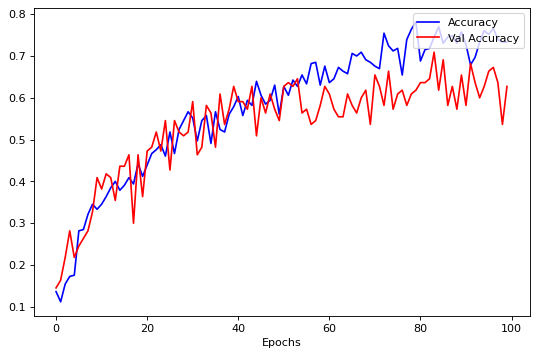

In [27]:
plt.figure(figsize=(8, 5), dpi= 80)
plt.plot(history.history['accuracy'],"b",label="Accuracy") 
plt.plot(history.history['val_accuracy'],"r",label="Val Accuracy") 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.show()

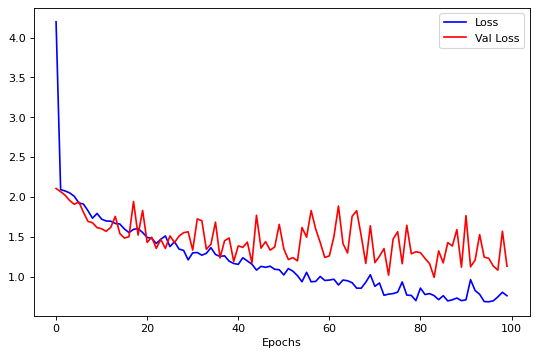

In [28]:
plt.figure(figsize=(8, 5), dpi= 80)
plt.plot(history.history['loss'],"b",label="Loss") 
plt.plot(history.history['val_loss'],"r",label="Val Loss") 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.show()

## Metrics

In [29]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [30]:
y_pred = model.predict(validation_generator) #The predicted labels
y_pred_classes = y_pred.argmax(axis=-1)
y_test_classes = validation_generator.labels

acc = accuracy_score(y_test_classes, y_pred_classes)
print("Test accuracy = {}".format(acc))  

4/4 [==============================] - 21s 5s/step
Test accuracy = 0.6272727272727273


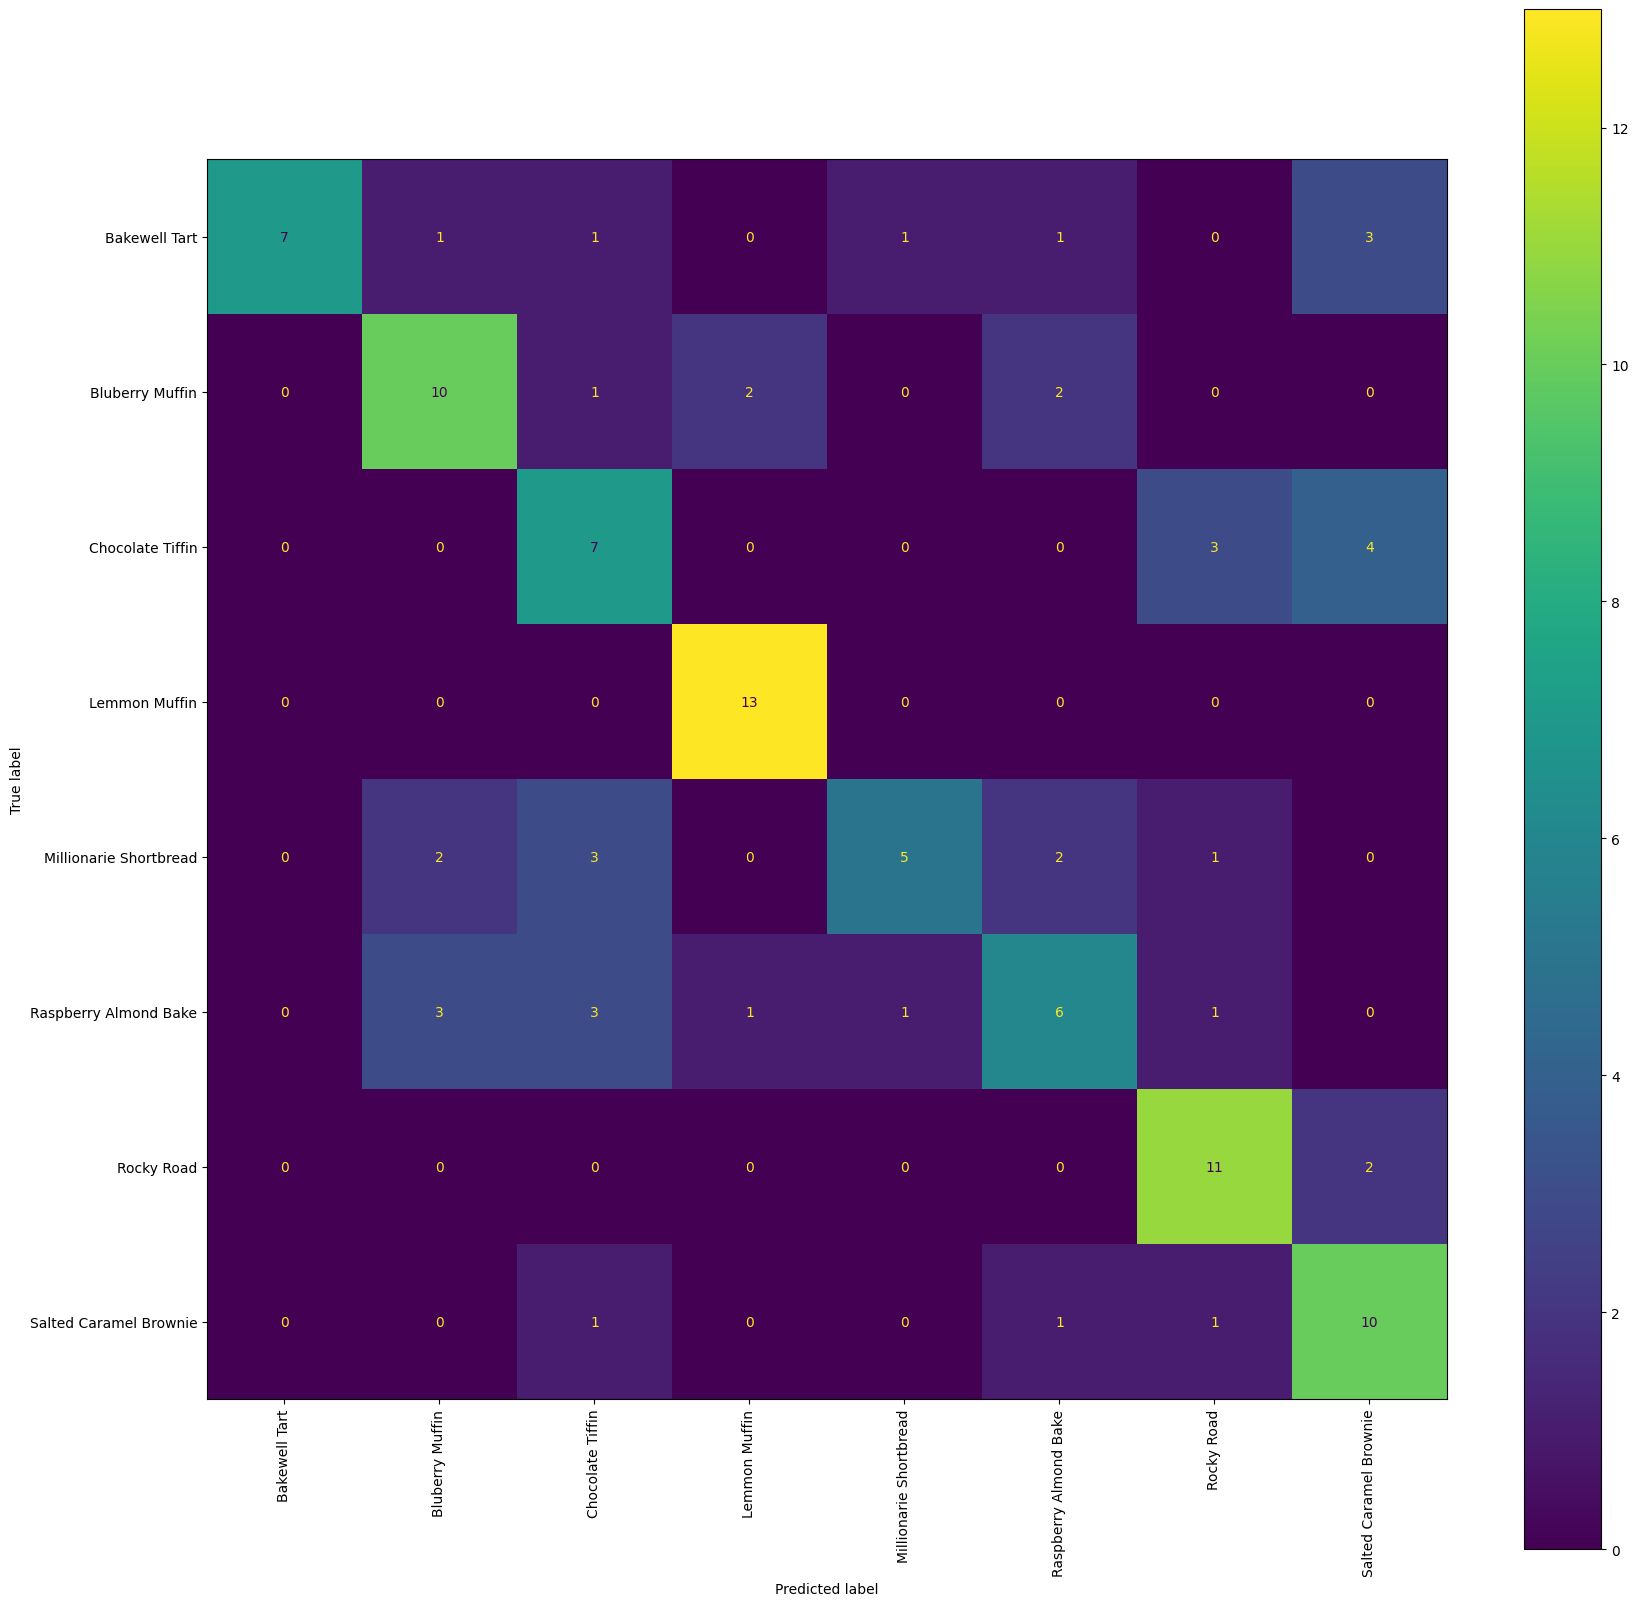

In [31]:
fig, ax = plt.subplots(figsize=(20,20))
cm=confusion_matrix(y_test_classes, y_pred_classes) #We create the confusion matrix, we feed it with the real labels and 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(df['label'].unique()))
disp.plot(ax=ax)
plt.xticks(rotation=90);
# disp.im_.colorbar.remove()

### See where the model made a mistake

In [32]:
label_map = sorted(df['label'].unique())

In [33]:
missed_prediction_indixes = np.where(~(y_test_classes == y_pred_classes))[0]

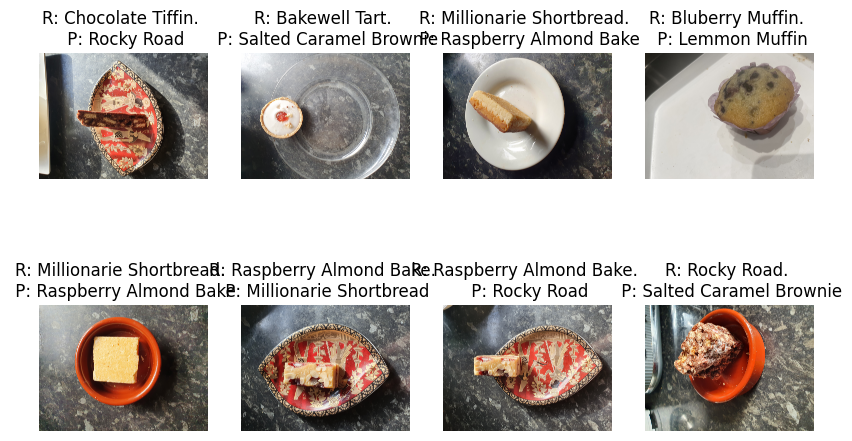

In [34]:
fig, axs = plt.subplots(2, 4, figsize=(10, 6)) # 2x4 plot
axs = axs.flatten() # Flatten the axes so we can access them with an index

for i, missed_index in enumerate(missed_prediction_indixes[:8]): # Let's iterate
    image_path = validation_generator.filepaths[missed_index]
    real_label = label_map[y_test_classes[missed_index]]
    image = mpimg.imread(image_path) # Read the image
    axs[i].imshow(image) # Show it
    predicted_class = label_map[y_pred_classes[missed_index]]
    axs[i].set_title(f"R: {real_label}. \n P: {predicted_class}") # add the title
    axs[i].axis('off') #remove the axis since it's a picture

# Approach 2. Transfer Learning

In [35]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [36]:
IMG_WIDTH = 128
IMG_HEIGHT = 128

In [37]:
train_datagen = ImageDataGenerator(
    validation_split=0.20, 
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

In [38]:
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='filepath',
    y_col='label',
    weight_col=None,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix='',
    save_format='png',
    subset=None,
    interpolation='nearest',
    validate_filenames=True,

)


validation_generator = val_datagen.flow_from_dataframe(
    df_test,
    x_col='filepath',
    y_col='label',
    weight_col=None,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=None,
    save_to_dir=None,
    save_prefix='',
    save_format='png',
    subset=None,
    interpolation='nearest',
    validate_filenames=True,
)

Found 330 validated image filenames belonging to 8 classes.
Found 111 validated image filenames belonging to 8 classes.


In [39]:
NUM_CATEGORIES

8

In [40]:
# Transfer learning
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

model = tf.keras.Sequential([base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(NUM_CATEGORIES, activation='softmax')
])

94765736/94765736 [==============================] - 3s 0us/step


In [41]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss="categorical_crossentropy",
                  metrics=['accuracy'])

In [42]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NUM_CATEGORIES, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
                  loss="categorical_crossentropy",
                  metrics=['accuracy'])

In [43]:
batch_size = 32
nb_epoch = 100

history = model.fit(train_generator,
          epochs=nb_epoch,
          shuffle = True,
          validation_data=validation_generator,
          callbacks = [ModelCheckpoint('model_resnet.h5', save_best_only=True)])

Epoch 1/100
11/11 [==============================] - 129s 8s/step - loss: 2.7682 - accuracy: 0.1394 - val_loss: 2.2782 - val_accuracy: 0.1802
Epoch 2/100
11/11 [==============================] - 92s 9s/step - loss: 2.5279 - accuracy: 0.1667 - val_loss: 1.9215 - val_accuracy: 0.3153
Epoch 3/100
11/11 [==============================] - 95s 9s/step - loss: 2.1168 - accuracy: 0.2485 - val_loss: 1.6731 - val_accuracy: 0.3604
Epoch 4/100
11/11 [==============================] - 95s 9s/step - loss: 1.9784 - accuracy: 0.2909 - val_loss: 1.4785 - val_accuracy: 0.4505
Epoch 5/100
11/11 [==============================] - 90s 8s/step - loss: 1.9011 - accuracy: 0.3212 - val_loss: 1.3194 - val_accuracy: 0.4955
Epoch 6/100
11/11 [==============================] - 84s 8s/step - loss: 1.7903 - accuracy: 0.3485 - val_loss: 1.1752 - val_accuracy: 0.5766
Epoch 7/100
11/11 [==============================] - 90s 9s/step - loss: 1.5677 - accuracy: 0.4394 - val_loss: 1.0662 - val_accuracy: 0.6486
Epoch 8/100


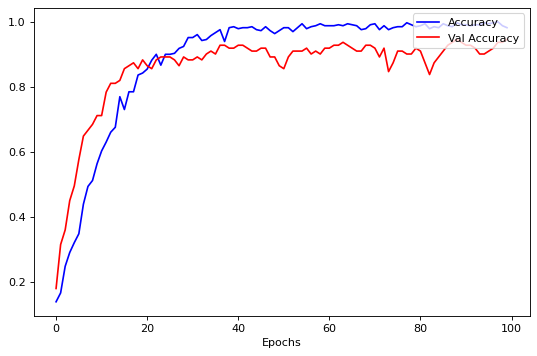

In [44]:
plt.figure(figsize=(8, 5), dpi= 80)
plt.plot(history.history['accuracy'],"b",label="Accuracy") 
plt.plot(history.history['val_accuracy'],"r",label="Val Accuracy") 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.show()

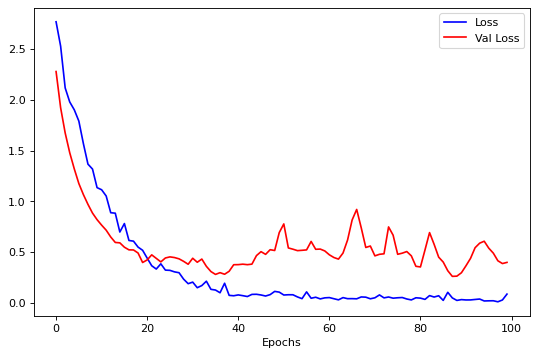

In [45]:
plt.figure(figsize=(8, 5), dpi= 80)
plt.plot(history.history['loss'],"b",label="Loss") 
plt.plot(history.history['val_loss'],"r",label="Val Loss") 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.show()

## Metrics

In [46]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [47]:
y_pred = model.predict(validation_generator) #The predicted labels
y_pred_classes = y_pred.argmax(axis=-1)
y_test_classes = validation_generator.labels

acc = accuracy_score(y_test_classes, y_pred_classes)
print("Test accuracy = {}".format(acc))  

4/4 [==============================] - 22s 5s/step
Test accuracy = 0.9459459459459459


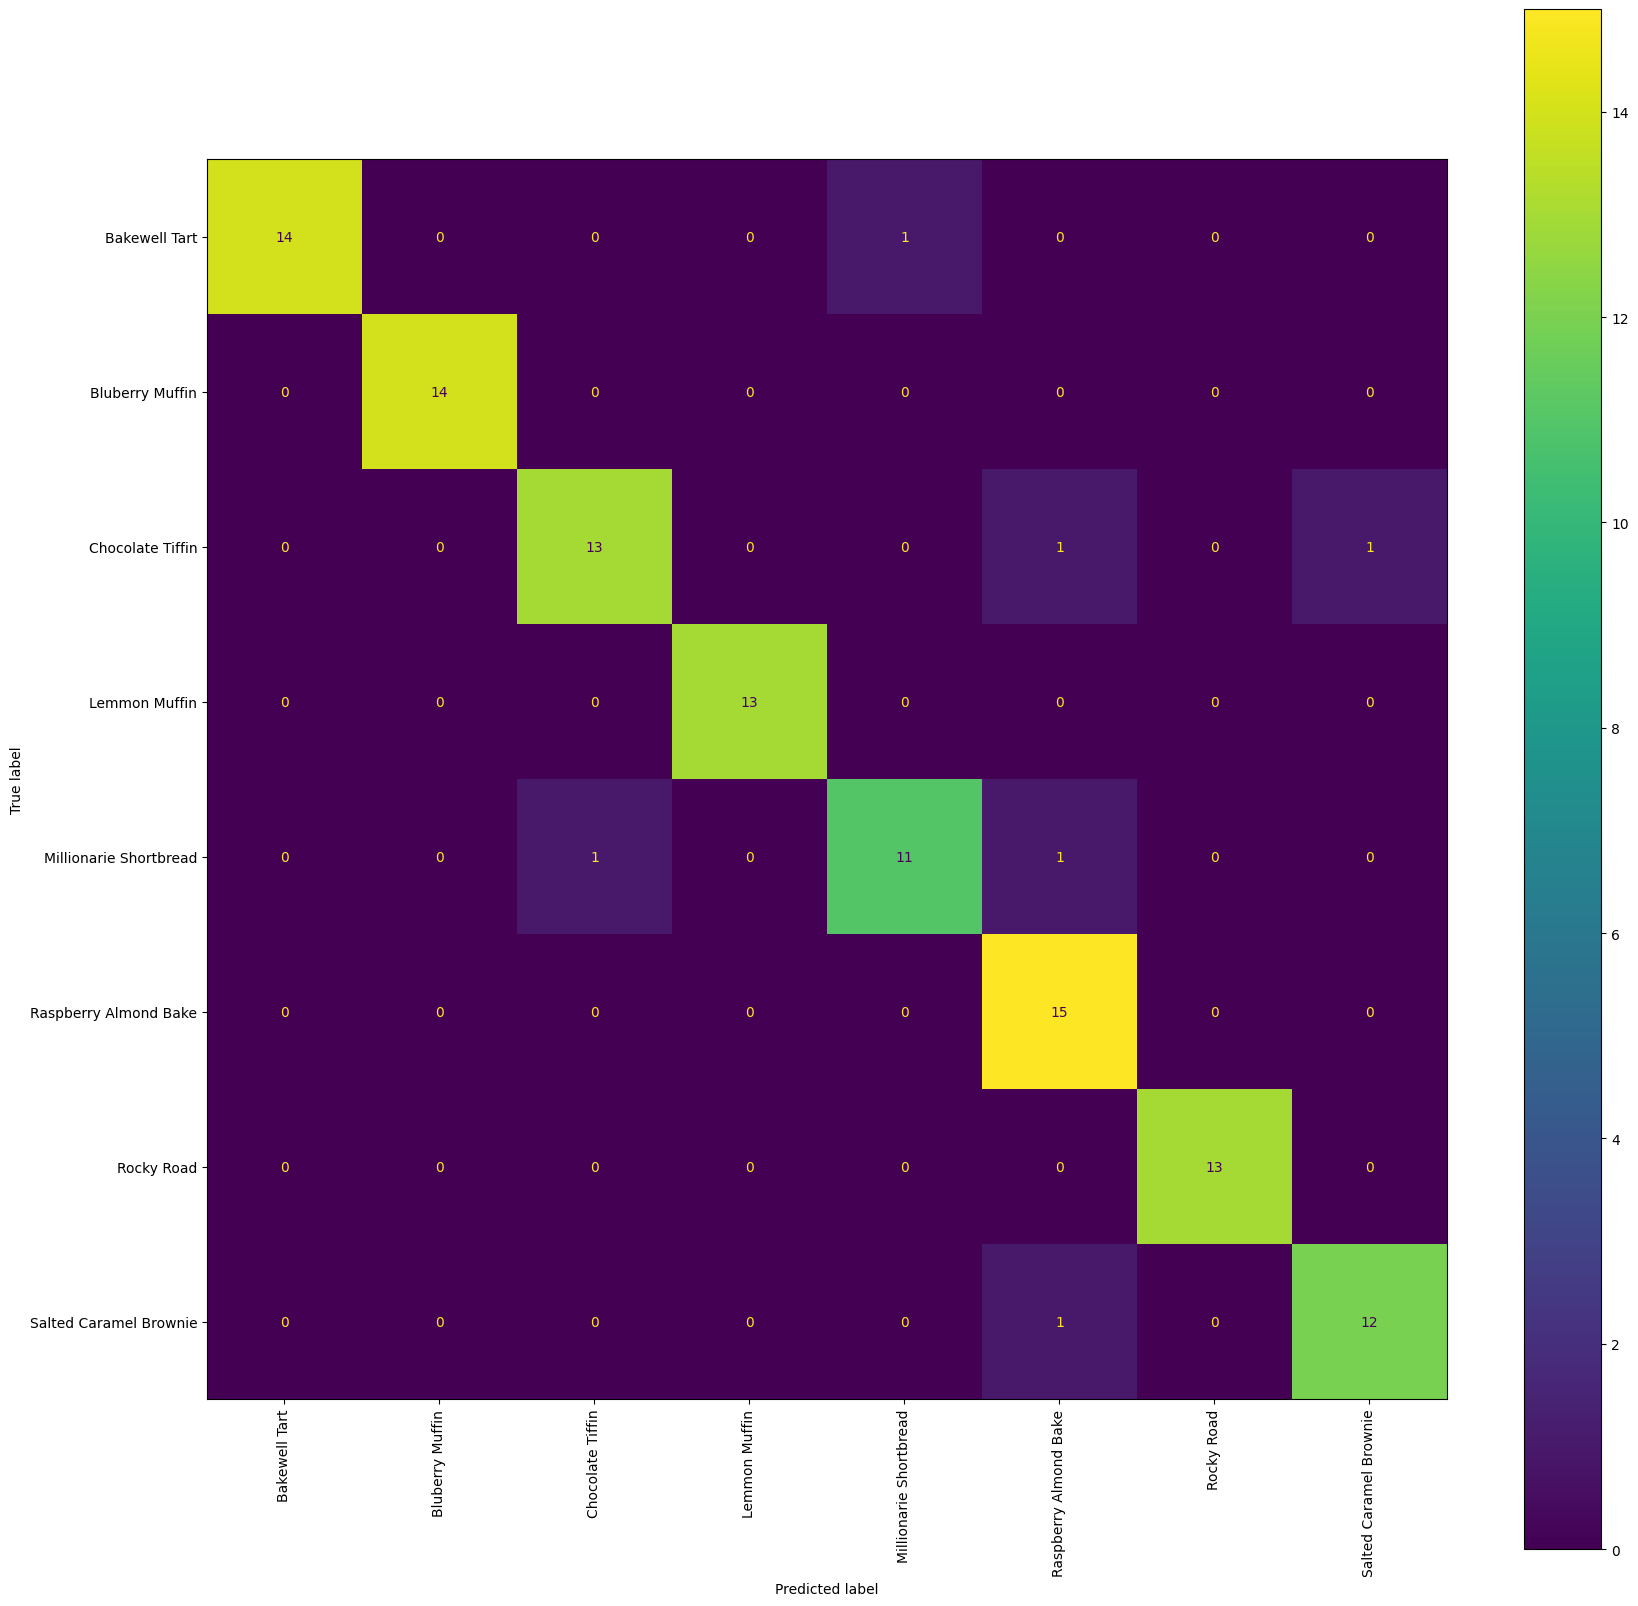

In [48]:
fig, ax = plt.subplots(figsize=(20,20))
cm=confusion_matrix(y_test_classes, y_pred_classes) #We create the confusion matrix, we feed it with the real labels and 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(df['label'].unique()))
disp.plot(ax=ax)
plt.xticks(rotation=90);
# disp.im_.colorbar.remove()

### See where the model made a mistake

In [49]:
label_map = list(sorted(df['label'].unique()))

In [50]:
missed_prediction_indixes = np.where(~(y_test_classes == y_pred_classes))[0]

IndexError: ignored

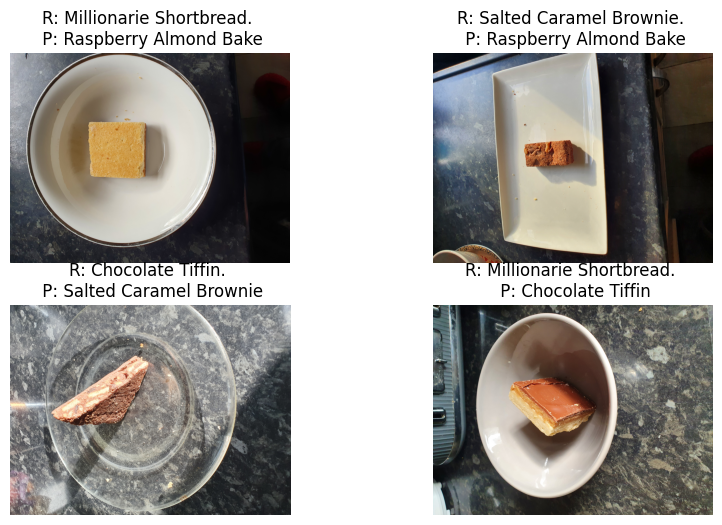

In [51]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6)) # 2x4 plot
axs = axs.flatten() # Flatten the axes so we can access them with an index

for i, missed_index in enumerate(missed_prediction_indixes[:8]): # Let's iterate
    image_path = validation_generator.filepaths[missed_index]
    real_label = label_map[y_test_classes[missed_index]]
    image = mpimg.imread(image_path) # Read the image
    axs[i].imshow(image) # Show it
    predicted_class = label_map[y_pred_classes[missed_index]]
    axs[i].set_title(f"R: {real_label}. \n P: {predicted_class}") # add the title
    axs[i].axis('off') #remove the axis since it's a picture